<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green">Проект по A/B тестированию</h1>

# Описание проекта

Цель - Оценить корректность проведения теста предшественника. 
Проанализировать результаты теста.

# Техническое задание

    Название теста: recommender_system_test;
    Группы: А (контрольная), B (новая платёжная воронка);
    Дата запуска: 2020-12-07;
    Дата остановки набора новых пользователей: 2020-12-21;
    Дата остановки: 2021-01-04;
    Аудитория: 15% новых пользователей из региона EU;
    Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
    Ожидаемое количество участников теста: 6000.
    Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
        - конверсии в просмотр карточек товаров — событие product_page
        - просмотры корзины — product_card
        - покупки — purchase.

# Описание данных

    ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
    Структура файла:
        name — название маркетингового события;
        regions — регионы, в которых будет проводиться рекламная кампания;
        start_dt — дата начала кампании;
        finish_dt — дата завершения кампании.

    final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
    Структура файла:
        user_id — идентификатор пользователя;
        first_date — дата регистрации;
        region — регион пользователя;
        device — устройство, с которого происходила регистрация.

    final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
    Структура файла:
        user_id — идентификатор пользователя;
        event_dt — дата и время события;
        event_name — тип события;
        details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

    final_ab_participants.csv — таблица участников тестов.
    Структура файла:
        user_id — идентификатор пользователя;
        ab_test — название теста;
        group — группа пользователя.

In [71]:
from matplotlib import pyplot as plt # выгружаем необходимые библиотеки
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import math as mt
from functools import reduce
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
import matplotlib as mpl
import seaborn as sb
import plotly.express as px
from plotly import graph_objects as go

In [72]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #изменение глобальной настройки отображения 

# Предподготовка данных

In [73]:
def info_data(data):
    '''Принимает таблицу, возвращает первые 15 строк, общую информацию, наличие пропусков и дубликатов'''
    print(data.head(15))
    display(data.info())
    print('Количество пропусков в таблце:', data.isnull().sum())
    print('Количество дубликатов в таблце:',data.duplicated().sum())

In [74]:
marketing_events = pd.read_csv('datasets/ab_project_marketing_events.csv') #календарь маркетинговых событий на 2020
info_data(marketing_events)

                                name                   regions    start_dt  \
0           Christmas&New Year Promo             EU, N.America  2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2             St. Patric's Day Promo             EU, N.America  2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4                  4th of July Promo                 N.America  2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America  2020-11-26   
6             Chinese New Year Promo                      APAC  2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC  2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC  2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS  2020-05-09   
10         CIS New Year Gift Lottery                       CIS  2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC  

None

Количество пропусков в таблце: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Количество дубликатов в таблце: 0


In [75]:
new_users = pd.read_csv('datasets/final_ab_new_users.csv') # все пользоваели, зарегистрировавшиеся в интернет-магазине
# в период с 7-21 декабря 2020г
info_data(new_users)
print('Дубликаты по user_id: ', new_users['user_id'].duplicated().sum())

             user_id  first_date     region   device
0   D72A72121175D8BE  2020-12-07         EU       PC
1   F1C668619DFE6E65  2020-12-07  N.America  Android
2   2E1BF1D4C37EA01F  2020-12-07         EU       PC
3   50734A22C0C63768  2020-12-07         EU   iPhone
4   E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
5   137119F5A9E69421  2020-12-07  N.America   iPhone
6   62F0C741CC42D0CC  2020-12-07       APAC   iPhone
7   8942E64218C9A1ED  2020-12-07         EU       PC
8   499AFACF904BBAE3  2020-12-07  N.America   iPhone
9   FFCEA1179C253104  2020-12-07         EU  Android
10  5EB159DA9DC94DBA  2020-12-07       APAC       PC
11  084A22B980BA8169  2020-12-07         EU  Android
12  8ACC2420471B31E4  2020-12-07         EU       PC
13  E6DE857AFBDC6102  2020-12-07         EU       PC
14  5BE017E9C8CC42F8  2020-12-07         EU  Android
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
--- 

None

Количество пропусков в таблце: user_id       0
first_date    0
region        0
device        0
dtype: int64
Количество дубликатов в таблце: 0
Дубликаты по user_id:  0


In [76]:
ab_events = pd.read_csv('datasets/final_ab_events.csv') #все события новых пользователей в период с 7 декабря 2020 по 
#4 января 2021 года
info_data(ab_events)

             user_id             event_dt event_name  details
0   E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase   99.990
1   7B6452F081F49504  2020-12-07 09:22:53   purchase    9.990
2   9CD9F34546DF254C  2020-12-07 12:59:29   purchase    4.990
3   96F27A054B191457  2020-12-07 04:02:40   purchase    4.990
4   1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase    4.990
5   831887FE7F2D6CBA  2020-12-07 06:50:29   purchase    4.990
6   6B2F726BFD5F8220  2020-12-07 11:27:42   purchase    4.990
7   BEB37715AACF53B0  2020-12-07 04:26:15   purchase    4.990
8   B5FA27F582227197  2020-12-07 01:46:37   purchase    4.990
9   A92195E3CFB83DBD  2020-12-07 00:32:07   purchase    4.990
10  E2E76A8B3389127C  2020-12-07 15:39:32   purchase    4.990
11  354D653172FF2A2D  2020-12-07 15:45:11   purchase    4.990
12  7FCD34F47C13A9AC  2020-12-07 22:06:13   purchase    9.990
13  0313C457F07C339E  2020-12-07 13:10:48   purchase    9.990
14  214902A9BAAF3422  2020-12-07 19:31:44   purchase    4.990
<class '

None

Количество пропусков в таблце: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Количество дубликатов в таблце: 0


In [77]:
final_participants = pd.read_csv('datasets/final_ab_participants.csv') # таблица участников тестов
info_data(final_participants)
print('Количество дубликатов по user_id: ', final_participants['user_id'].duplicated().sum())

             user_id group                  ab_test
0   D1ABA3E2887B6A73     A  recommender_system_test
1   A7A3664BD6242119     A  recommender_system_test
2   DABC14FDDFADD29E     A  recommender_system_test
3   04988C5DF189632E     A  recommender_system_test
4   482F14783456D21B     B  recommender_system_test
5   4FF2998A348C484F     A  recommender_system_test
6   7473E0943673C09E     A  recommender_system_test
7   C46FE336D240A054     A  recommender_system_test
8   92CB588012C10D3D     A  recommender_system_test
9   057AB296296C7FC0     B  recommender_system_test
10  B3A2485649E4A012     A  recommender_system_test
11  E9FA12FAE3F5769C     B  recommender_system_test
12  FDD0A1016549D707     A  recommender_system_test
13  547E99A7BDB0FCE9     A  recommender_system_test
14  66FC298441D50783     A  recommender_system_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   ---------

None

Количество пропусков в таблце: user_id    0
group      0
ab_test    0
dtype: int64
Количество дубликатов в таблце: 0
Количество дубликатов по user_id:  1602


In [78]:
s = final_participants.groupby('user_id').ab_test.count()
bad_users = s[s>1].index.to_list() # Пользователи, которые есть больше чем в одном АБ-тесте
cleaned_participants = final_participants.query('user_id not in @bad_users and ab_test == "recommender_system_test"')


Найдено 1602 дубликатов в таблице распределения пользователей по тестовым группам. При детальном рассмотрении одного из примеров, становится понятно, что в таблице присутствует и пересекаются пользователи по конкурирующим тестам. После применения фильтра по интересующему тесту дубликаты отсутствуют. Так, в данных обнаружено 1602 пересечения с другими тестами. Удалили все дубли и все наблюдения из не рассматриваемого тестирования.

In [79]:
c = cleaned_participants.groupby('user_id').ab_test.count()
non_unique = c[c > 1].index.to_list()
print('Количество участников теста:', c.count())
print(non_unique)

Количество участников теста: 5099
[]


In [80]:
group_count = cleaned_participants.pivot_table(index='group', values='user_id', aggfunc='count')

In [81]:
group_count

,user_id
group,
A,2903
B,2196


Разница в выборках составляет больше 1%. Уравнивать группы потерей 1000 наблюдений - нецелесообразно и не корректно. Уравнивать имеет смысл при проведении A/A тестирования. Также, нарушены условия технического задания (6000 участников теста).

In [82]:
def datetime(data,column):
    """Принимает датасет и столбец, меняет тип данных на datetime, выводит на экран общую информацию по датасету"""
    data[column] = pd.to_datetime(data[column])
    print(data.info())

In [83]:
datetime(marketing_events,'start_dt')
datetime(marketing_events,'finish_dt')
datetime(new_users,'first_date')
datetime(ab_events,'event_dt')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 576.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (tota

In [84]:
marketing_events.sort_values('start_dt') # проверяем пересечение аб теста с календарем маркетинговых активностей


,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


In [85]:
print('Минимальное время события:',ab_events['event_dt'].min())
print('Максимальное время события:',ab_events['event_dt'].max())

Минимальное время события: 2020-12-07 00:00:33
Максимальное время события: 2020-12-30 23:36:33


События заканчиваются 30.12.2020. Если сегодня, 31.12.2020, то события для тестирования еще нужно дособрать. Если сегодня 8 января 2021, то не собраны события за 5 дней тестирования, либо по какой-то причине они не попали в датасет для анализа. 

In [86]:
print('Минимальное время события:',new_users['first_date'].min())
print('Максимальное время события:',new_users['first_date'].max())

Минимальное время события: 2020-12-07 00:00:00
Максимальное время события: 2020-12-23 00:00:00


Данные о регистрациях содержат действия за 22 и 23 декабря. Так как, по техническому заданию, регистрации должны закончиться 21.12., удалим более поздние регистрации и регистрации, с момента которыйх не прошло 2 недель.

In [87]:
new_users = new_users.query('first_date <= "2020-12-16 00:00:00"')
print('Максимальное время регистрации:',new_users['first_date'].max())

Максимальное время регистрации: 2020-12-16 00:00:00


In [89]:
participants_with_userinfo = pd.merge(cleaned_participants, new_users, on='user_id', how='left')

In [90]:
enriched_events = pd.merge(participants_with_userinfo, ab_events, on='user_id', how='left')

In [91]:
enriched_events

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.990
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.990
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,nan
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,nan
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,nan
...,...,...,...,...,...,...,...,...,...
21110,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,nan
21111,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,nan
21112,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,nan
21113,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,nan


In [92]:
participants_with_userinfo.count()/participants_with_userinfo.query('region == "EU"').count()

user_id      1.680
group        1.680
ab_test      1.680
first_date   1.075
region       1.075
device       1.075
dtype: float64

In [93]:
len(enriched_events['user_id'].unique())

5099

# Вывод по шагу "предподготовка данных"

Изучив данные и техническое задание, обнаружены следующие критические моменты, ставящие под вопрос целенаправленность дальнейших действий по анализу теста в поставленных условиях.
1.     Время проведения теста. Совпадает с 2 маркетинговыми активностями и 1 в интересующем нас регионе (EU);
2.     Аудитория теста. В предоставленных данных найдены пересечения с конкурирующим тестом. Тестовые группы распределены неравномерно.
3. Данные собраны не зна весь период теста.
Данный тест логичнее перенести на вторую половину января (если нас не интересует аудитория Китая). Т.к. в новогодние праздники покупательская активность сильно меняется. 

# Исследовательский анализ данных

In [94]:
enriched_events['event_name'].value_counts().sort_values()

purchase        2483
product_cart    2522
product_page    5298
login           8501
Name: event_name, dtype: int64

Судя по количеству событий, чаще всего, что логично, пользователь авторизируется на сайте (login). Далее, в идевльном мире, переходит на страницу с оффером (product_page), добавляет товар в корзину (product_cart) и оплачивает покупку (purchase).

In [95]:
print('Количество и доля уникальных пользователей, совершивших каждое событие')
uid_count = enriched_events.groupby(['event_name','group']).agg({'user_id':'nunique'}).\
sort_values(by='user_id',ascending=False).reset_index()
uid_count['percent'] = uid_count['user_id'] / 5099 * 100
print(uid_count)

Количество и доля уникальных пользователей, совершивших каждое событие
     event_name group  user_id  percent
0         login     A     2082   40.832
1  product_page     A     1360   26.672
2         login     B      706   13.846
3      purchase     A      652   12.787
4  product_cart     A      631   12.375
5  product_page     B      397    7.786
6      purchase     B      198    3.883
7  product_cart     B      195    3.824


Выборки имеют одинаковое количество типов событий. При этом, очевидно, что уже на этапе авторизации, участники группы А более активны, как и в последующих этапах. Из 2196 зарегистрировавшихся пользователей группы В, авторизовались только 706. В группе А 2082 из 2903. Стоит дополнительно разобрать природу регистраций пользователей из группы В. Также, важно, отметить, что за период каждый пользователь авторизовывался около 4 раз. Остальные действия, также, совершаются чаще 1 раза. Возможно, данные предоставлены в разрезе каждого товара, а не общей покупки.

In [96]:
events_by_day = enriched_events.pivot_table(index = [enriched_events.event_dt.dt.date,'group'], 
                                        columns = 'event_name', values='user_id', aggfunc = 'count')#.reset_index()

In [97]:
events_by_day

event_name         login  product_cart  product_page  purchase
event_dt   group                                              
2020-12-07 A     109.000        25.000        70.000    30.000
           B     124.000        36.000        83.000    47.000
2020-12-08 A     121.000        30.000        86.000    30.000
           B      87.000        26.000        44.000    26.000
2020-12-09 A     135.000        35.000        83.000    43.000
           B     128.000        36.000        81.000    28.000
2020-12-10 A     122.000        33.000        72.000    38.000
           B      96.000        29.000        51.000    20.000
2020-12-11 A     137.000        35.000        77.000    33.000
           B      64.000        16.000        31.000    11.000
2020-12-12 A     134.000        40.000        79.000    29.000
           B      79.000        14.000        39.000    22.000
2020-12-13 A     126.000        29.000        73.000    25.000
           B      60.000        12.000        26.000    17.000
2020-12-14 A     366.000       114.000       239.000   104.000
           B     106.000        31.000        52.000    28.000
2020-12-15 A     361.000       127.000       237.000   109.000
           B      89.000        24.000        41.000    20.000
2020-12-16 A     356.000       115.000       226.000   113.000
           B     130.000        45.000        80.000    36.000
2020-12-17 A     402.000       141.000       264.000   120.000
           B      97.000        37.000        53.000    22.000
2020-12-18 A     429.000       134.000       293.000   120.000
           B     106.000        35.000        48.000    24.000
2020-12-19 A     506.000       174.000       339.000   161.000
           B     112.000        33.000        60.000    23.000
2020-12-20 A     521.000       170.000       331.000   171.000
           B     125.000        27.000        67.000    30.000
2020-12-21 A     683.000       191.000       453.000   223.000
           B     157.000        45.000        86.000    49.000
2020-12-22 A     461.000       137.000       298.000   137.000
           B      72.000        12.000        34.000    24.000
2020-12-23 A     349.000        98.000       220.000    95.000
           B      81.000        17.000        36.000    21.000
2020-12-24 A     288.000        87.000       197.000    96.000
           B      56.000        18.000        28.000    15.000
2020-12-25 A     223.000        56.000       159.000    84.000
           B      45.000         9.000        25.000     9.000
2020-12-26 A     195.000        59.000       121.000    68.000
           B      45.000         9.000        26.000     8.000
2020-12-27 A     194.000        63.000       128.000    61.000
           B      48.000        12.000        22.000    15.000
2020-12-28 A     154.000        52.000       101.000    45.000
           B      39.000         5.000        21.000     7.000
2020-12-29 A     153.000        44.000       104.000    38.000
           B      29.000         4.000        14.000     8.000
2020-12-30 B       1.000         1.000           nan       nan

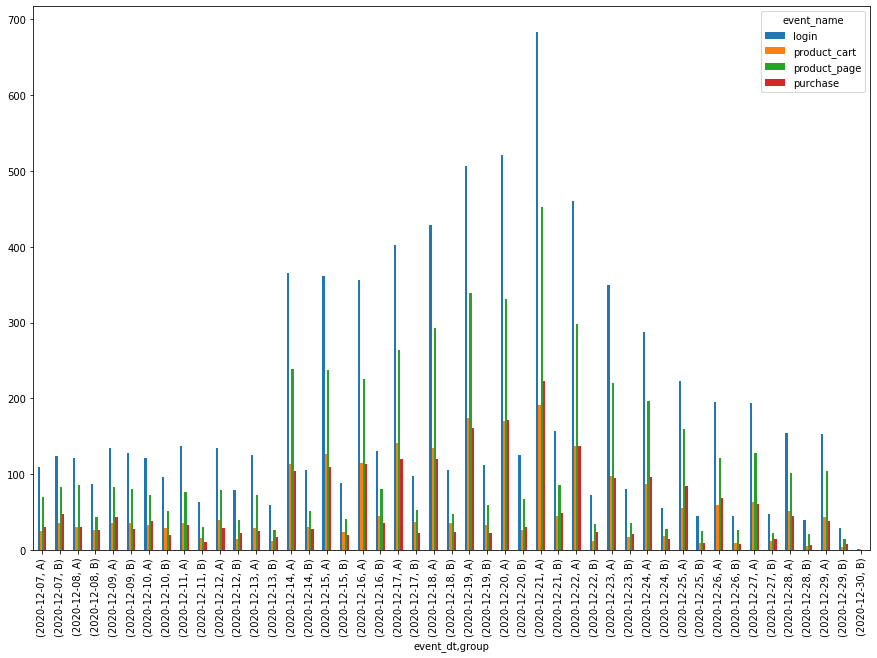

In [98]:
events_by_day.plot.bar(figsize=(15,10));

Очевидно, что количество событий в группе А растет до 21.12, в самый активный день, количество событий превышает аналогичный показатель в начале тестирования в 7 раз. Такой показатель логичен и объясняется высокой потребительской активнойстью в канун праздников. Активность пользователей из группы В меняется не линейно. Динамика имеет место в период с 17 по 21.12., но из-за разности в выборках, результаты группы В в сравнении более скромные. Рассмотрим конверсионные показатели.
Важно отметить, что есть дни, в которые покупок больше, чем посещений корзины. Возможно происхожили прямые переходы на страницу оплаты, либо в магазине реализована возможность оплаты "за 1 клик", которая перевожит клиента сразу на страницу оплаты, в обход корзины. Важно понимать точную механику, т.к. расчет конверсии из корзины в оплату может быть некорректен.

###  Воронка событий

In [99]:
uid_count1 = enriched_events.pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='min')
uid_count1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2788 entries, 0010A1C096941592 to FFAE9489C76F352B
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   login         2788 non-null   datetime64[ns]
 1   product_cart  826 non-null    datetime64[ns]
 2   product_page  1757 non-null   datetime64[ns]
 3   purchase      850 non-null    datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 108.9+ KB


In [100]:
print('Доля авторизовавшихся из общего количества зарегистрировавшихся:', (uid_count1['login'].\
      count() / 5099)*100)
print('Конверсия из авторизовавшихся в просмотр оффера:', uid_count1['product_page'].count() /\
     uid_count1['login'].count()*100)
print('Конверсия из просмотра оффера в переход в корзину:', uid_count1['product_cart'].count() /\
     uid_count1['product_page'].count()*100)
print('Конверсия из перехода в корзину в успешную оплату:', uid_count1['purchase'].count() /\
     uid_count1['product_cart'].count()*100)
print('Доля пользователей, дошедших до успешной оплаты от общего количества:',\
      (uid_count1['purchase'].count() / 5099)*100)

Доля авторизовавшихся из общего количества зарегистрировавшихся: 54.67738772308296
Конверсия из авторизовавшихся в просмотр оффера: 63.020086083213776
Конверсия из просмотра оффера в переход в корзину: 47.01195219123506
Конверсия из перехода в корзину в успешную оплату: 102.90556900726394
Доля пользователей, дошедших до успешной оплаты от общего количества: 16.66993528142773


In [117]:
fig = go.Figure()
for name in ['A','B']:
    f = uid_count.query('group == @name').copy()
    funnel= f.reset_index().reindex([0,1,3,2])
    fig.add_trace(
       go.Funnel(
         name = name,
          y = funnel['event_name'],
          x = funnel['user_id'],
           orientation = "h",
        textinfo = "value+percent initial"
       )
    )
fig.update_layout(title='Воронка событий')
fig.show()

Больше всего пользователей "теряется" на этапе перехода с главной страницы на страницу с выбором. Вероятно, проблема в формированием потребности. Возможно, часть пользователей заходят в магазин из рассылок, баннеров или других маркетинговых инстументов ошибочно или заходят в магазин для уточнения информации, не касающейся заказа (контактная информация, отследить заказ, оформленный ранее). 
Также, 35% и 28% на заканчивают оформление заказа и закрывают сайт, не заходя в корзину. 

Только 13.2 - 13.8% пользователей от общего количества завершает использование сайта оплатой.

# Результаты эксперимента

In [140]:
group_data = enriched_events.pivot_table\
(index='event_name', columns='group', values='user_id', aggfunc='nunique').reindex(['login','product_page', 'product_cart', 'purchase'])
group_data

group,A,B
event_name,,
login,2082,706
product_page,1360,397
product_cart,631,195
purchase,652,198


In [147]:
"Применим гипотезу о равенстве долей" # только для первых конверсий. конверсию в покупку считать
#некорректно, т.к. неизвестен предыдущий шаг и конверсия из просмотра корзины больше 100%

#Нулевая гипотеза: Доли по количеству пользователей тестируемых групп равны.
#Альтернативная гипотеза: Доли по количеству пользователей тестируемых групп отличаются.
def stat_realibility (df, column1, column2, alpha):
   
    events = df.index 
    for i in range(1, 3):
        alpha = alpha
        bonferroni = alpha / 16 # Чтобы снизить групповую вероятность ошибки первого рода и 
        #скорректировать требуемые уровни значимости применим метод Бонферрони
        row1 = np.array([df.loc[events[i-1], column1], df.loc[events[i-1], column2]])
        row2 = np.array([df.loc[events[i], column1], df.loc[events[i], column2]])
       
        p1 = row2[0] / row1[0]
        p2 = row2[1] / row1[1]
        p_combined = (row2[0] + row2[1]) / (row1[0] + row1[1])
        print(p_combined)
        difference = p1 - p2
        z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/row1[0] + 1/row1[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if (p_value < bonferroni):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


In [148]:
stat_realibility (group_data, "A","B", 0.05)

0.6302008608321378
p-значение:  1.5371909704686715e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница
0.4701195219123506
p-значение:  0.3391735536469258
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Изменим уровень статистической значимости, чтобы минимизировать возможность ложного результата.

In [146]:
stat_realibility (group_data, "A","B", 0.01)

0.6302008608321378
p-значение:  1.5371909704686715e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница
0.4701195219123506
p-значение:  0.3391735536469258
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Вывод по результату эксперимента.
Уменьшение уровня статистической разницы не изменило результат. На этапе перехода пользователя из авторизации к офферу, доли разные. В конверсии из оффера в переход к корзине -  нет оснований считать доли групп разными.

## Общий вывод

По итогам эксперимента, мы не можем подтвердить однозначное различие в долях, но и  не можем утверждать обратного. Доли в конверсиях разные на начале пути пользователя и совпадают на следующем этапе.

Т.к. механика проведения теста нарушена, отмечены факторы, искажающие реальный результат: 
- данные собраны не по техническому заданию, за короткий промежуток времени, на малой выборке.Тестовые группы распределены неравномерно, разница в объеме больше 1 %;
- данные собраны в период аномального пользовательского поведения (рождестверские, новогодние праздники;
- время тестирования совпадает с 2 маркетинговыми активностями и 1 в интересующем нас регионе (EU);
- нет пояснений к техзаданию (15% новых пользователей из региона EU), если нас интересует 85% других регионов, то данные собраны не полностью;
- для корректного рассчета воронки необходимо понимать технические особенности сайта, в данном случае - как именно пользователь может совершить покупку. Исключить возможность бага.

Результатам текущего исследования можно доверять (в рамках текущего периода и в рамках выборки), но сложно принимать решения , основываясь на них. Данный тест логичнее перенести на вторую половину января (если нас не интересует аудитория Китая). Т.к. в новогодние праздники покупательская активность сильно меняется. Любой результат и все гипотезы, которые мы сейчас подтвердим или опровергнем, могут показать совершенно другие результаты, например, весной, когда покупательское поведение будет другое. 

Также, необходимо подготовить корректные данные для теста. Равномерно распределенные группы для анализа при условии исключения возможности пересечения с другими тестами, путем корректно поставленной задачи разработчикам.

Так, компания, возможно, понесет дополнительные расходы, но получит корректные данные для принятия дальнейших решений в интересах дальнейшего развития.


